# Big Store Analysis

## Table of Contents <a id='back'></a>
* [Introduction](#intro)
* [Data Preprocessing](#preprocess)
* [Part 1: Prioritizing Hypothesis](#part1)
* [Part 2: A/B Test Analysis](#part2)
    * [Metrics](#metrics)
        * [Cumulative Revenue](#cumul_revenue)
        * [Cumulative Average Order Size](#cumul_order_size)
        * [Conversion Rate](#conversion)
    * [Detecting Outliers and Anomalies](#outliers)
        * [Orders per User](#orders_users)
        * [Order Prices](#orders_prices)
        * [Excluding outliers](#excluding)
    * [Statistical Analysis](#statistical)
        * [Difference in Conversion Between Groups](#dif_conversion)
        * [Difference in Average Order Size Between Groups](#dif_order_size)
* [Conclusions](#conclusion)

## Introduction <a id='intro'></a>

At Big Store, a leading online retail platform, we are continuously exploring strategies to enhance revenue. In collaboration with the Marketing Department, we have compiled a series of hypotheses that could potentially drive revenue growth. Our task is to prioritize these hypothesis effectively, conduct an A/B test, and analyze the outcomes to determine the best course of action.

## Data Overview and Preprocessing <a id='preprocess'></a>

Before diving into the analysis, it is crucial to preprocess the data to ensure reliability. 

In [1]:
# import necessary libraries
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from scipy import stats
import math

In [2]:
try:
    hypotheses = pd.read_csv('hypotheses_us.csv', sep=';')
except:
    hypotheses = pd.read_csv('/datasets/hypotheses_us.csv', sep=';')

In [3]:
try:
    orders = pd.read_csv('orders_us.csv', sep=',', parse_dates=['date'])
except:
    orders = pd.read_csv('/datasets/orders_us.csv', sep=',', parse_dates=['date'])

In [4]:
try:
    visits = pd.read_csv('visits_us.csv', parse_dates=['date'])
except:
    visits = pd.read_csv('/datasets/visits_us.csv', parse_dates=['date'])

Let's start with the `hypotheses` table.

In [5]:
hypotheses

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1
5,Add a customer review page. This will increase...,3,2,2,3
6,Show banners with current offers and sales on ...,5,3,8,3
7,Add a subscription form to all the main pages....,10,7,8,5
8,Launch a promotion that gives users discounts ...,1,9,9,5


We have nine distinct hypotheses, each with their respective scores for Reach, Impact, Confidence, and Effort. These scores will later be used to prioritize the hypotheses. We'll just adjust column names for easier handling.

In [6]:
# Changing all column names to lower case
for col in hypotheses.columns:
    hypotheses.rename(columns={col: col.lower()}, inplace=True)

There is no further preprocessing needed in this table. Let's continue with the `orders` table.

In [7]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


We have 5 columns, with the transaction and user identifiers, the date of the transaction, the revenue from each order and the testing group to which the user was assigned. Let's start by adjusting some of the column names for standarization and checking for duplicated and missing values.

In [8]:
# Changing column names to snake case
orders.rename(columns={'transactionId': 'transaction_id', 'visitorId': 'visitor_id'}, inplace=True)
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   float64       
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 46.9+ KB


In [9]:
orders.duplicated().sum()

0

In [10]:
orders['date'].describe()

count                             1197
mean     2019-08-15 13:06:46.015037696
min                2019-08-01 00:00:00
25%                2019-08-08 00:00:00
50%                2019-08-15 00:00:00
75%                2019-08-23 00:00:00
max                2019-08-31 00:00:00
Name: date, dtype: object

The dates of test were from the 1st to 31st of August 2019. We have no missing values or duplicated entries in this table. Let's check whether there are users that have been assigned to both test groups.

In [11]:
# visitor/users that have been assinged to group A
group_a_cnt = orders[orders['group']=='A'].groupby('visitor_id').agg({'transaction_id': 'nunique'}).reset_index()
group_a_cnt.rename(columns={'transaction_id': 'transactions_cnt'}, inplace=True)
#group_a_cnt.head()

In [12]:
# visitor/users that have been assinged to group B
group_b_cnt = orders[orders['group']=='B'].groupby('visitor_id').agg({'transaction_id': 'nunique'}).reset_index()
group_b_cnt.rename(columns={'transaction_id': 'transactions_cnt'}, inplace=True)
#group_b.head()

In [13]:
# visitor/users that have been assigned to both groups
users_a = set(group_a_cnt['visitor_id'])
users_b = set(group_b_cnt['visitor_id'])

dup_users = users_a.intersection(users_b)

dup_users_df = orders[orders['visitor_id'].isin(dup_users)].sort_values('visitor_id')
dup_users_df.head(10)

,transaction_id,visitor_id,date,revenue,group
703,4293855558,8300375,2019-08-07,30.5,A
71,3679129301,8300375,2019-08-01,165.7,B
823,2971973105,199603092,2019-08-27,45.9,A
246,437656952,199603092,2019-08-02,55.7,B
26,2223239646,199603092,2019-08-15,55.7,A
134,62794304,199603092,2019-08-22,110.3,A
1102,1941707234,199603092,2019-08-12,100.0,A
1009,2670069237,232979603,2019-08-31,45.6,B
1013,83566152,232979603,2019-08-31,5.9,A
590,3702128013,237748145,2019-08-20,20.8,A


In [14]:
len(dup_users)

58

There are 58 users who have been assigned to both groups. Since having users in both groups would affect the integrity and validity of the analysis, we will exclude all entries from those users.

In [15]:
orders_raw = orders #keeping the raw data
orders = orders[~orders['visitor_id'].isin(dup_users)]
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B


Let's take a look at the distribution of revenue.

In [16]:
orders['revenue'].describe()

count     1016.000000
mean       130.770866
std        648.079810
min          5.000000
25%         20.775000
50%         50.100000
75%        126.950000
max      19920.400000
Name: revenue, dtype: float64

The maximum value for the revenue is extremely high compared to the mean and the median, indicating the presence of outliers in the dataset. The difference between the mean and the median suggests that the data is right-skewed. The high value of the standard deviation indicates high variability. Let's visualize the data with a box plot to get a better sense of the distribution.

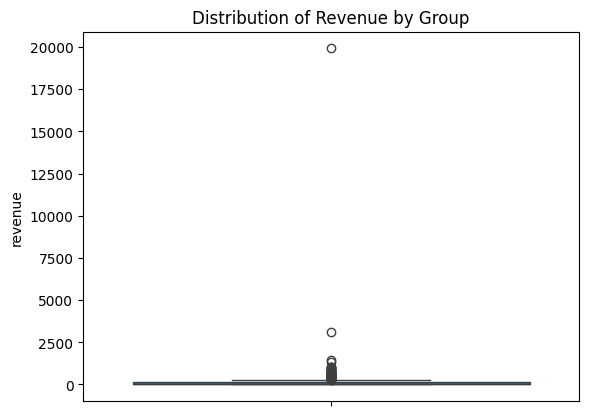

In [17]:
# Plotting distribution of revenue in a box plot.
sns.boxplot(data= orders, y= 'revenue')
plt.title('Distribution of Revenue by Group')

plt.show()

It is evident that the maximum value is an outlier, to an extent that we cannot visualize the distribution in this plot. We can alsoidentify other potential outliers. We will analyze those outliers in more detail later in the analysis.

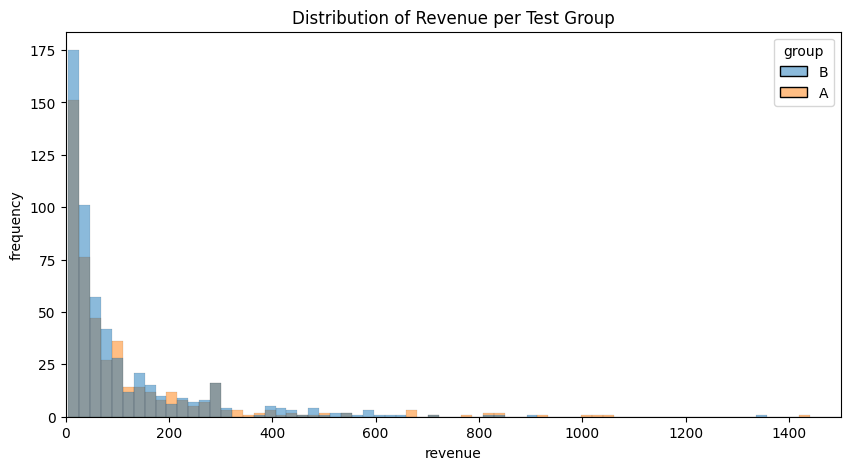

In [18]:
# Plotting the distribution of the revenue by test group in a histogram
custom_palette = {'A': '#FF7F0A', 'B': '#1976B9'} 

fig, ax = plt.subplots(figsize=(10, 5))

sns.histplot(data= orders, x= 'revenue', hue= 'group', palette=custom_palette, ax=ax)

ax.set_xlim(0, 1500) # showing up until 1000 for easier visualization
ax.set_ylabel('frequency')
ax.set_title('Distribution of Revenue per Test Group')

plt.show()

It appears that Group B has more data across most revenue bins, suggesting that there might be more orders in Group B overall. However, the highest expenses seem to come from Group A (Note that this histogram shows the revenue up until 1500; higher values are almost imperceptible in this graph). The distributions for both groups seem to be similar, but it is difficult to determine this from the graph alone. We will explore this further in Part 2 of the analysis.

In [19]:
len(orders[orders['group'] == 'B']) - len(orders[orders['group'] == 'A'])

80

In [20]:
orders.loc[orders['group'] == 'B', 'visitor_id'].nunique() - orders.loc[orders['group'] == 'A', 'visitor_id'].nunique()

83

We have 80 more entries in group B than in group A. We also have 83 more distinct users in group B. This seems to be a significant difference that can introduce bias into the results.

In [21]:
print(orders.loc[orders['group']== 'A', 'revenue'].sum())
print(orders.loc[orders['group']== 'B', 'revenue'].sum())

53211.99999999999
79651.20000000001


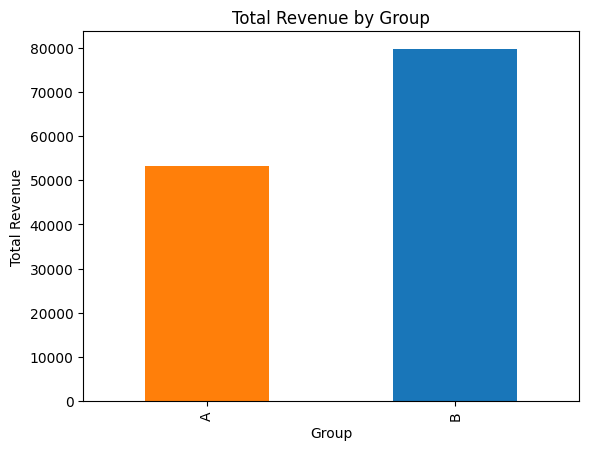

In [22]:
revenue_by_group = orders.groupby('group')['revenue'].sum()

revenue_by_group.plot(kind='bar', color=[custom_palette[group] for group in revenue_by_group.index])

plt.xlabel('Group')
plt.ylabel('Total Revenue')
plt.title('Total Revenue by Group')

plt.show()

Even though the histogram seemed to show more frequent high-value transactions for group A (up until 1500 in revenue), we can see that the total revenue generated from group B is higher. This might be due to the higher number of users and transactions from group B and the outliers already indentified.

Lastly, let's revise the `visits` table:

In [23]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     object        
 2   visits  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [24]:
visits.duplicated().sum()

0

In the `visits` table, we have 3 columns that describe the number of visits per date for each group. There are no missing values or duplicated entries.

In [25]:
visits['date'].describe()

count                     62
mean     2019-08-16 00:00:00
min      2019-08-01 00:00:00
25%      2019-08-08 06:00:00
50%      2019-08-16 00:00:00
75%      2019-08-23 18:00:00
max      2019-08-31 00:00:00
Name: date, dtype: object

The range of dates is the same for both tables and the corresponding columns with the dates for each table has already be changed to datetime type. No additional changes are required. 

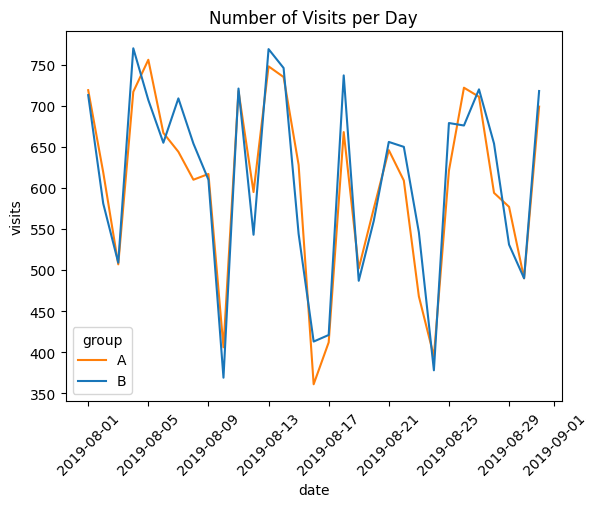

In [26]:
# Plotting visits per day
sns.lineplot(data=visits, x='date', y='visits', palette=custom_palette, hue='group')

plt.xticks(rotation=45)
plt.title('Number of Visits per Day')

plt.show()

The user behavior in terms of daily visits seems to be similar for both groups. We will explore this further in Part 2 of the analysis. 

 [⬆ Back to Contents](#back)

## Part 1: Prioritizing Hypotheses <a id='part1'></a>

To maximize growth of key business metrics, the hypothesis have to be prioritized. This part ot the project involves the prioriztion of nine hypotheses aimed at boosting Big Store's revenue. These hypotheses have been evaluated on four key parameters: Reach, Impact, Confidence, and Effort. We applied the `RICE` and the `ICE` methods and compared their results. 

Let's start by taking a look at the hypotheses.

In [27]:
for h in range(len(hypotheses['hypothesis'])):
    print(f"{h+1}. {hypotheses.loc[h, 'hypothesis']}.")
    print()

1. Add two new channels for attracting traffic. This will bring 30% more users.

2. Launch your own delivery service. This will shorten delivery time.

3. Add product recommendation blocks to the store's site. This will increase conversion and average purchase size.

4. Change the category structure. This will increase conversion since users will find the products they want more quickly.

5. Change the background color on the main page. This will increase user engagement.

6. Add a customer review page. This will increase the number of orders.

7. Show banners with current offers and sales on the main page. This will boost conversion.

8. Add a subscription form to all the main pages. This will help you compile a mailing list.

9. Launch a promotion that gives users discounts on their birthdays.



We will first rank the hypotheses using the `ICE` method. Its name stands for Impact, Confidence and Effort (or Ease), where:

- **Impact** refers to how strongly users will be affected by the change (experience, satisfaction...).
- **Confidence** refers to how certain we are that the change will result in the expected impact.
- **Effort** refers to how many resources will the implementation of the hypothesis require (money, time, people...).

All of the factors are in a scale from 1 to 10.

In [28]:
# Calculating scores for ICE method
hypotheses['ice'] = round((hypotheses['impact'] * hypotheses['confidence']) / hypotheses['effort'], 2)

hypotheses.sort_values('ice', ascending=False)

,hypothesis,reach,impact,confidence,effort,ice
8,Launch a promotion that gives users discounts ...,1,9,9,5,16.20
0,Add two new channels for attracting traffic. T...,3,10,8,6,13.33
7,Add a subscription form to all the main pages....,10,7,8,5,11.20
6,Show banners with current offers and sales on ...,5,3,8,3,8.00
2,Add product recommendation blocks to the store...,8,3,7,3,7.00
1,Launch your own delivery service. This will sh...,2,5,4,10,2.00
5,Add a customer review page. This will increase...,3,2,2,3,1.33
3,Change the category structure. This will incre...,8,3,3,8,1.12
4,Change the background color on the main page. ...,3,1,1,1,1.00


Now we will calculate the scores for prioritization using the `RICE` method. It uses the same components of the `ICE` method, with an additional criterion, Reach.

 - **Reach** refers to the number of users that will be impacted by the changes resulting from the implementation of the hypothesis. 
 
This factor is also on a scale from 1 to 10. 

In [29]:
# Calculating scores for RICE method
hypotheses['rice'] = (hypotheses['reach'] * hypotheses['impact'] * hypotheses['confidence']) / hypotheses['effort']

hypotheses.sort_values('rice', ascending=False)

,hypothesis,reach,impact,confidence,effort,ice,rice
7,Add a subscription form to all the main pages....,10,7,8,5,11.20,112.0
2,Add product recommendation blocks to the store...,8,3,7,3,7.00,56.0
0,Add two new channels for attracting traffic. T...,3,10,8,6,13.33,40.0
6,Show banners with current offers and sales on ...,5,3,8,3,8.00,40.0
8,Launch a promotion that gives users discounts ...,1,9,9,5,16.20,16.2
3,Change the category structure. This will incre...,8,3,3,8,1.12,9.0
1,Launch your own delivery service. This will sh...,2,5,4,10,2.00,4.0
5,Add a customer review page. This will increase...,3,2,2,3,1.33,4.0
4,Change the background color on the main page. ...,3,1,1,1,1.00,3.0


Although both `ICE` and `RICE` are effective methods of prioritization, we can see that the addition of the Reach factor results in a difference in the prioritization score for all of our hypotheses. The use of one method over the other depends on whether the Reach (the scope of the impact) is a critical factor in the evaluation process. It is iportant to take into account the nature of the project when choosing between these methods.

 [⬆ Back to Contents](#back)

## Part 2: A/B Test Analysis <a id='part2'></a>

Following the hypotheses prioritization, we conducted an A/B test. Now we will analyze the results of the test using data on transactions and visits during the test period. 

### Metrics <a id='metrics'></a>

#### Cumulative Revenue <a id='cumul_revenue'></a>
We will start by taking a look at the behavior of the users over the time of the test. First, let's analyze the cumulative revenue by group.

In [30]:
# Separating groups A and B in different dfs
group_a = orders[orders['group'] == 'A']
group_b = orders[orders['group'] == 'B']

In [31]:
# Aggregating group A by date
group_a_daily = group_a.groupby('date').agg(n_transactions=('transaction_id', 'nunique'), n_visits=('visitor_id','count'), n_visitors=('visitor_id', 'nunique'), total_revenue=('revenue', 'sum')).reset_index()
group_a_daily['revenue_cumul'] = group_a_daily['total_revenue'].cumsum()
group_a_daily.head(3)

,date,n_transactions,n_visits,n_visitors,total_revenue,revenue_cumul
0,2019-08-01,23,23,19,2266.6,2266.6
1,2019-08-02,19,19,18,1468.3,3734.9
2,2019-08-03,24,24,24,1815.2,5550.1


In [32]:
# Aggregating group B by date
group_b_daily = group_b.groupby('date').agg(n_transactions=('transaction_id', 'nunique'), n_visits=('visitor_id','count'), n_visitors=('visitor_id', 'nunique'), total_revenue=('revenue', 'sum')).reset_index()
group_b_daily['revenue_cumul'] = group_b_daily['total_revenue'].cumsum()
group_b_daily.head(3)

,date,n_transactions,n_visits,n_visitors,total_revenue,revenue_cumul
0,2019-08-01,17,17,17,967.2,967.2
1,2019-08-02,23,23,22,2568.1,3535.3
2,2019-08-03,14,14,14,1071.6,4606.9


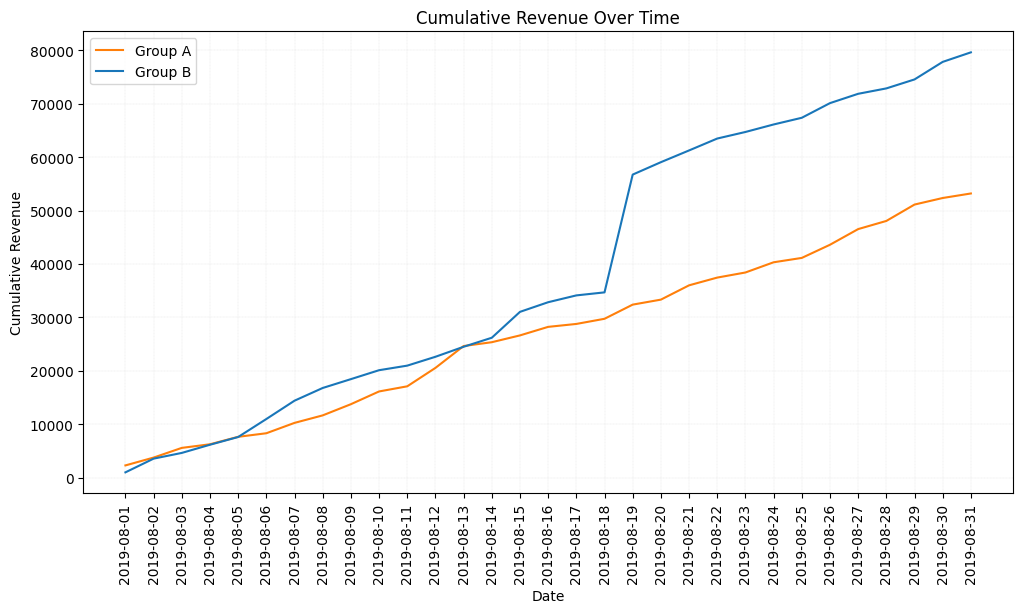

In [33]:
# Plotting the cumulative revenue for each group
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(group_a_daily['date'], group_a_daily['revenue_cumul'], label='Group A', color=custom_palette['A'])
ax.plot(group_b_daily['date'], group_b_daily['revenue_cumul'], label='Group B', color=custom_palette['B'])

ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Revenue')
ax.set_title('Cumulative Revenue Over Time')
ax.legend()

ax.set_xticks(group_a_daily['date'])
ax.grid(True, which='major', linestyle='--', linewidth=0.2, color='lightgray')

plt.xticks(rotation=90)


plt.show()

Here we can see that Group A presents a higher cumulative revenue than Group B for the first four days of the test, after which Group B starts to experience an increasing trend. From August 5 until the end of the test, Group B maintains a higher cumulative revenue, with the exception of Augusts 13, when the cumulative revenue of Group A even surpasses that of Group B. There is a significant spike for group B on August 19, which influences all the subsequent values. The rate of revenue accumulation appears to be steadier for Group A.

Overall, as seen before, Group B has generated more revenue during this period. 

 [⬆ Back to Contents](#back)

#### Cumulative Average Order Size <a id='cumul_order_size'></a>

Next, we'll examine the cumulative average order size to understand the overall trend and behavior changes of the groups over time. To do this, we will calculate the average order size for each day by dividing the total revenue by the number of transactions for that day. Then, we will determine the cumulative average order size for each date throughout the test period.

In [34]:
group_a_daily['order_size_avg'] = group_a_daily['total_revenue'] / group_a_daily['n_transactions']
group_a_daily['transactions_cumul'] = group_a_daily['n_transactions'].cumsum()
group_a_daily['order_size_avg_cumul'] = group_a_daily['revenue_cumul']/group_a_daily['transactions_cumul']
#group_a_daily

In [35]:
group_b_daily['order_size_avg'] = group_b_daily['total_revenue'] / group_b_daily['n_transactions']
group_b_daily['transactions_cumul'] = group_b_daily['n_transactions'].cumsum()
group_b_daily['order_size_avg_cumul'] = group_b_daily['revenue_cumul']/group_b_daily['transactions_cumul']
#group_b_daily

In [36]:
group_a_daily.head(10)

,date,n_transactions,n_visits,n_visitors,total_revenue,revenue_cumul,order_size_avg,transactions_cumul,order_size_avg_cumul
0,2019-08-01,23,23,19,2266.6,2266.6,98.547826,23,98.547826
1,2019-08-02,19,19,18,1468.3,3734.9,77.278947,42,88.926190
2,2019-08-03,24,24,24,1815.2,5550.1,75.633333,66,84.092424
3,2019-08-04,11,11,11,675.5,6225.6,61.409091,77,80.851948
4,2019-08-05,22,22,22,1398.0,7623.6,63.545455,99,77.006061
5,2019-08-06,15,15,12,668.4,8292.0,44.560000,114,72.736842
6,2019-08-07,16,16,16,1942.0,10234.0,121.375000,130,78.723077
7,2019-08-08,14,14,14,1404.8,11638.8,100.342857,144,80.825000
8,2019-08-09,11,11,11,2095.2,13734.0,190.472727,155,88.606452
9,2019-08-10,15,15,15,2387.5,16121.5,159.166667,170,94.832353


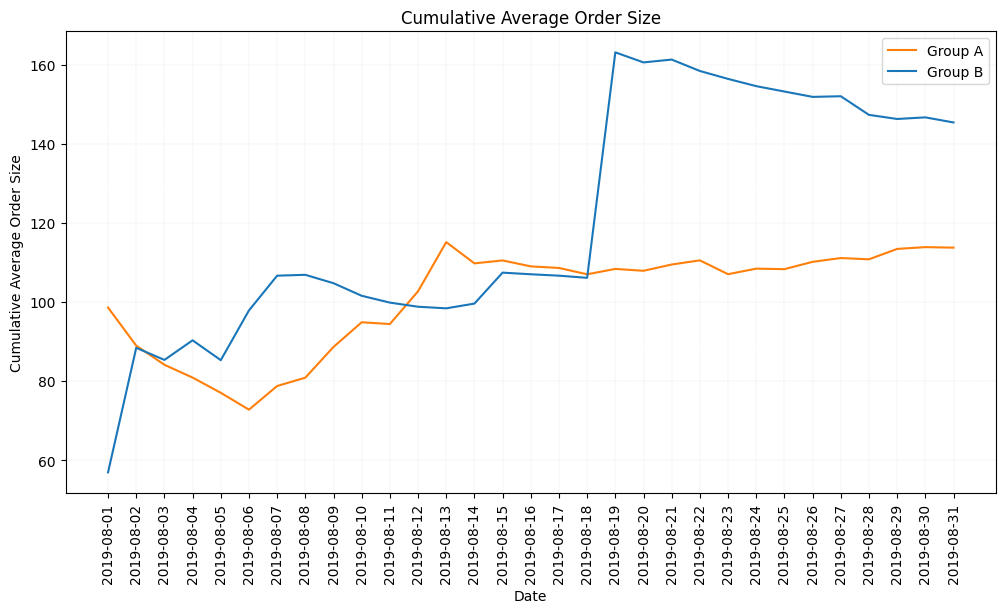

In [37]:
# Plotting the cumulative average order size for each group
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(group_a_daily['date'], group_a_daily['order_size_avg_cumul'], label='Group A', color=custom_palette['A'])
ax.plot(group_b_daily['date'], group_b_daily['order_size_avg_cumul'], label='Group B', color=custom_palette['B'])

ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Average Order Size')
ax.set_title('Cumulative Average Order Size')
ax.legend()

ax.set_xticks(group_a_daily['date'])
ax.grid(True, which='major', linestyle='--', linewidth=0.2, color='lightgray')

plt.xticks(rotation=90)

plt.show()

Shortly after the beginning of the test, the cumulative average order size of Group B increases over Group A. Around a week into the test, Group A experiences a significant increase in its cumulative average order size, overtaking Group B, a trend that persists until the spike observed in group B on August 19. Although group B maintains a higher cumulative average order size for most of the period, we have to keep into consideration the higher number of users in this group, as well as the high-value transactions that inflate this metric.

Towards the end of the test period, the metrics appear to begin to stabilize, however, it is difficult to interpret from this graph alone. This might suggest the possible need to extend the test period. To further understand the behavior in terms of average order size without the cumulative influence of high-value transactions, let's examine the daily variations by looking into the average order size per day.

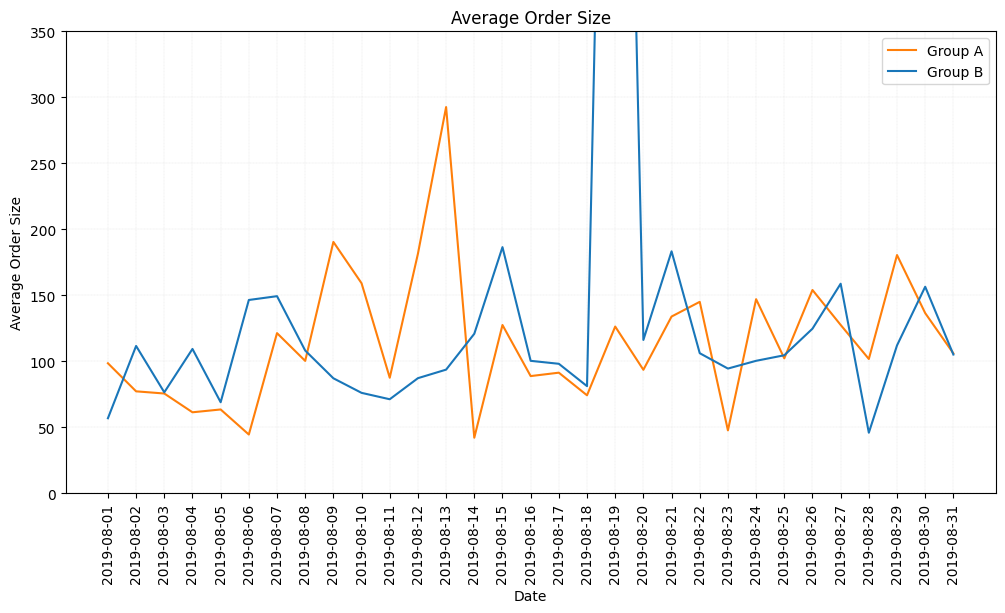

In [38]:
# Plotting daily average order size for each group
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(group_a_daily['date'], group_a_daily['order_size_avg'], label='Group A', color=custom_palette['A'])
ax.plot(group_b_daily['date'], group_b_daily['order_size_avg'], label='Group B', color=custom_palette['B'])

ax.set_xlabel('Date')
ax.set_ylabel('Average Order Size')
ax.set_title('Average Order Size')
ax.legend()

ax.set_xticks(group_a_daily['date'])

plt.xticks(rotation=90)

ax.grid(True, which='major', linestyle='--', linewidth=0.2, color='lightgray')
ax.set_ylim(0, 350)


plt.show()

*Note: we have limited the y-axis to a maximum value of 350, to get a clearer picture of the daily average order size, disregarding the huge spike in group B.*

When examining the daily average order size, we observe high variability in both groups, with group A presenting a noticeable spike on August 13 within this range (although low compared to the spike in group B). Although both groups experience fluctuations, group A shows more volatility (both high peaks and low values). This variability could be due to a smaller number of high-value transactions in Group A, as opposed to a relatively more stable performance in Group B (when disregarding August 19).

To better understand these trends and make the difference between the groups more obvious, let's analyze the **relative difference in the cumulative average order size** for group B compared with group A.

In [39]:
cumulative_a = group_a_daily[['date', 'transactions_cumul',  'revenue_cumul', 'order_size_avg_cumul']]
cumulative_b = group_b_daily[['date', 'transactions_cumul',  'revenue_cumul', 'order_size_avg_cumul']]

cumulative_merged = cumulative_a.merge(cumulative_b, on='date', suffixes=['_a', '_b'])
cumulative_merged['relative_dif'] = relative_difference = cumulative_merged['order_size_avg_cumul_b'] / cumulative_merged['order_size_avg_cumul_a'] - 1

In [40]:
cumulative_merged.head()

,date,transactions_cumul_a,revenue_cumul_a,order_size_avg_cumul_a,transactions_cumul_b,revenue_cumul_b,order_size_avg_cumul_b,relative_dif
0,2019-08-01,23,2266.6,98.547826,17,967.2,56.894118,-0.422675
1,2019-08-02,42,3734.9,88.926190,40,3535.3,88.382500,-0.006114
2,2019-08-03,66,5550.1,84.092424,54,4606.9,85.312963,0.014514
3,2019-08-04,77,6225.6,80.851948,68,6138.5,90.272059,0.116511
4,2019-08-05,99,7623.6,77.006061,89,7587.8,85.256180,0.107136


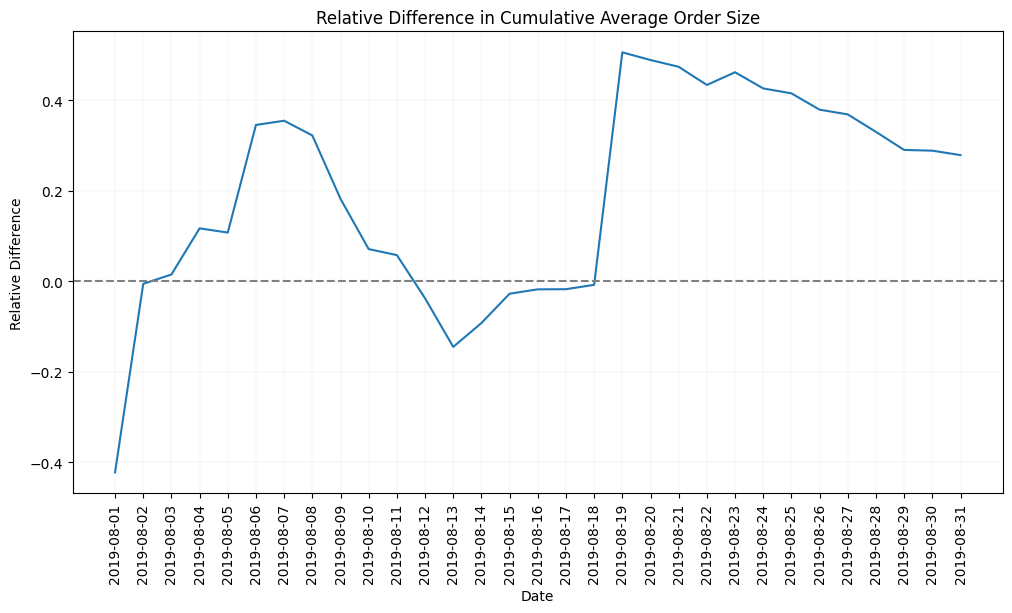

In [41]:
# Plotting relative difference for average order size
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(cumulative_merged['date'], cumulative_merged['relative_dif'])

ax.set_xlabel('Date')
ax.set_ylabel('Relative Difference')
ax.set_title('Relative Difference in Cumulative Average Order Size')

ax.set_xticks(group_a_daily['date'])

plt.xticks(rotation=90) 
plt.axhline(y=0, color='gray', linestyle='--')


ax.grid(True, which='major', linestyle='--', linewidth=0.2, color='lightgray')


plt.show()

The graph shows the relative performance of group B compared to group A, where group B reaches a better performance than group A at the beginning of the test, approximately over 0.35 within the first week. This indicates that the cumulative average order size of group B reached about 35% higher than group A at this point. After a week into the test, the relative difference begins to decline, becoming negative and reaching its lower point towards the middle of the month. After that, group B's cumulative average order size remains lower until the spike of August 19. From that point the cumulative values are less reliable, as they are influenced by this significant outlier.

 [⬆ Back to Contents](#back)

#### Conversion Rate <a id='conversion'></a>

We'll proceed to calculate and analyze the conversion rate for each day.

In [42]:
visits_pivot = visits.pivot(index='date', columns='group', values='visits').reset_index()
visits_pivot.columns = ['date', 'visits_a', 'visits_b']

visits_pivot.head()

,date,visits_a,visits_b
0,2019-08-01,719,713
1,2019-08-02,619,581
2,2019-08-03,507,509
3,2019-08-04,717,770
4,2019-08-05,756,707


In [43]:
conversion = group_a_daily[['date', 'n_visitors']].merge(group_b_daily[['date', 'n_visitors']], on='date', suffixes=['_a', '_b'])
conversion = conversion.merge(visits_pivot, on='date')

conversion['conversion_a'] = conversion['n_visitors_a'] / conversion['visits_a']
conversion['conversion_b'] = conversion['n_visitors_b'] / conversion['visits_b']

conversion.head()

,date,n_visitors_a,n_visitors_b,visits_a,visits_b,conversion_a,conversion_b
0,2019-08-01,19,17,719,713,0.026426,0.023843
1,2019-08-02,18,22,619,581,0.029079,0.037866
2,2019-08-03,24,14,507,509,0.047337,0.027505
3,2019-08-04,11,13,717,770,0.015342,0.016883
4,2019-08-05,22,21,756,707,0.029101,0.029703


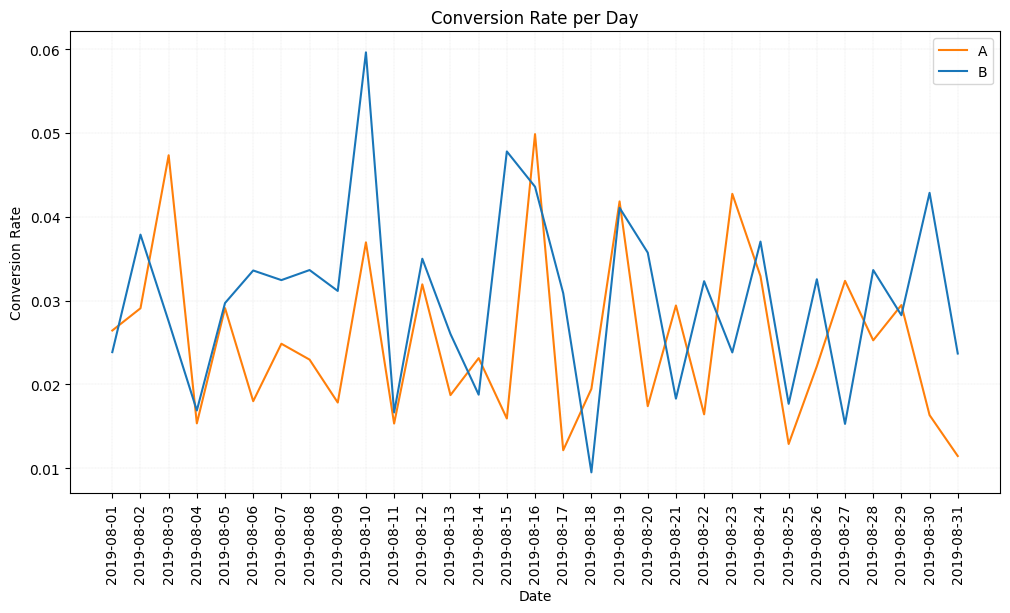

In [44]:
# Plotting conversion rate per day
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(conversion['date'], conversion['conversion_a'], label='A', color=custom_palette['A'])
ax.plot(conversion['date'], conversion['conversion_b'], label='B', color=custom_palette['B'])

ax.set_xlabel('Date')
ax.set_ylabel('Conversion Rate')
ax.set_title('Conversion Rate per Day')
ax.legend()

ax.set_xticks(group_a_daily['date'])
ax.grid(True, which='major', linestyle='--', linewidth=0.2, color='lightgray')

plt.xticks(rotation=90) 

plt.show()

Similar to the average order size, the conversion rate per day presents fluctuations throughout the month, indicating variablility in the users behavior. In this case, btoh groups show days with higher conversions, suggesting that neither group consistently outperforms the other. We do not see any clear pattern of behavior. 

In [45]:
# Overall conversion rates
conversion_a = group_a_daily['n_visitors'].sum() / visits_pivot['visits_a'].sum() * 100
conversion_b = group_b_daily['n_visitors'].sum() / visits_pivot['visits_b'].sum() * 100

print(f'Conversion Group A: {conversion_a:.2f}%')
print(f'Conversion Group B: {conversion_b:.2f}%')

Conversion Group A: 2.44%
Conversion Group B: 2.88%


The overall conversion rate for both groups for the test period are very similar. Further we will perform a statistical analysis on the average performance over the month to draw a more definite conclusion about the overall effectiveness of the changes being tested.

 [⬆ Back to Contents](#back)

### Detecting Outliers and Anomalies <a id='outliers'></a>

#### Orders per User <a id='orders_users'></a>

Before getting into the statistical analysis, let's examine the orders to identify the data points that are outliers/anomalies, which can distort the results of the test. We want to identify outliers in the amount of orders per users and in order size.

Let's plot a scatter chart with the number of orders per user:

In [46]:
orders_visitors = orders.groupby('visitor_id').agg({'transaction_id': 'nunique', 'revenue': 'sum'}).reset_index()
orders_visitors.rename(columns={'transaction_id': 'n_transactions'}, inplace=True)

#orders_visitors.sort_values('n_transactions', ascending=False).head()

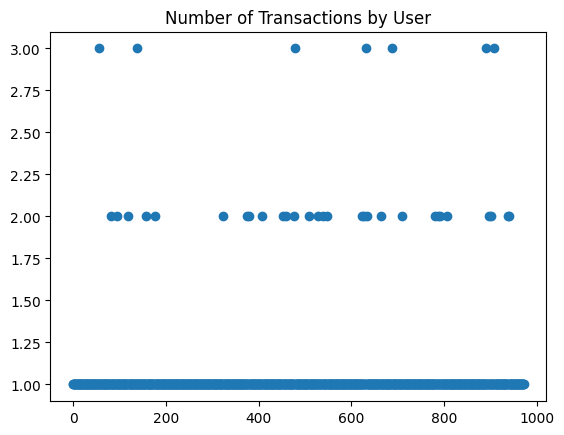

In [47]:
x_values = pd.Series(range(0, len(orders_visitors['visitor_id'])))

plt.scatter(x_values, orders_visitors['n_transactions'])
plt.title('Number of Transactions by User')

plt.show()

We have users with 1, 2 and 3 transactions. Although there fewer users with two and three transactions compared to those with only one, this number of transactions in a month does not seem to be extreme enough to be considered outliers. However, if it deviates from the typical behavior, it might influence the results of the test. To better understand this typical behavior and identify potential outliers, we can calculate the 95th and 99th percentiles of the number of transactions:

In [48]:
percentiles_orders = np.percentile(orders_visitors['n_transactions'], [95, 99])
print(f'95th: {percentiles_orders[0]}')
print(f'99th: {percentiles_orders[1]}')

95th: 1.0
99th: 2.0


Only 1% of the users made 3 transactions. We we'll consider those as outliers.

 [⬆ Back to Contents](#back)

#### Order Prices <a id='orders_prices'></a>

We have already seen the distribution of revenue in our data and we know that there are values that will distort the results. To get a better idea of which values might represent anomalies, we'll visualize it in a scatter plot.

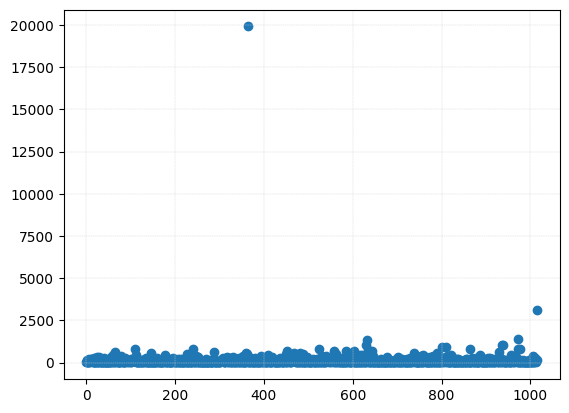

In [49]:
x_values = pd.Series(range(0, len(orders['revenue'])))

plt.scatter(x_values, orders['revenue'])
plt.grid(True, which='major', linestyle='--', linewidth=0.3, color='lightgray')

plt.show()

In [50]:
orders[orders['revenue'] >= 2500]

,transaction_id,visitor_id,date,revenue,group
425,590470918,1920142716,2019-08-19,19920.4,B
1196,3936777065,2108080724,2019-08-15,3120.1,B


We have already indentified that the maximum value is an outlier, with a value close to 20000. In the plot we can see another value that deviates from what seems to be normal, with a value over 3000. Both values belong to group B, which help explain the behavior previously observed. Generally, the most extreme 1-5% of observed values are considered outliers and are filtered out. Let's calculate the 95th and 99th percentiles for the order prices.

In [51]:
percentiles_revenue = np.percentile(orders['revenue'], [95, 99])
print(f'95th: {percentiles_revenue[0]}')
print(f'99th: {percentiles_revenue[1]}')

95th: 414.275
99th: 830.3


In [52]:
# Number of orders over 95th and 99th percentile thresholds
print(orders.loc[orders['revenue'] > percentiles_revenue[0], 'revenue'].count())
print(orders.loc[orders['revenue'] > percentiles_revenue[1], 'revenue'].count())

51
9


No more than 5% of the orders cost more than \\$414.25 and no more than 1% cost \\$830.3. Although these values seem low compared to the obvious outliers seen in the scatter plot, they still represent values that deviate from the typical behavior of our users. There are 51 and 9 values above the 95th and 99th percentiles, respectively. 

Since there are so many values above the 95th percentile, we will choose a less aggressive approach and filter out only outliers above the 99th percentile. This way, we will retein more data while still reducing the impact of the most extreme outliers. 

 [⬆ Back to Contents](#back)

#### Excluding Outliers <a id='excluding'></a>

In [53]:
# Outliers - users with many orders (99th percentile)
orders_out = orders_visitors.loc[orders_visitors['n_transactions'] > percentiles_orders[1], 'visitor_id']
orders_out

55      249864742
138     611059232
478    2108163459
632    2742574263
687    2988190573
890    3908431265
908    3967698036
Name: visitor_id, dtype: int64

In [54]:
# Outliers - transactions with high order prices (99th percentile)
prices_out = orders.loc[orders['revenue'] > percentiles_revenue[1], 'transaction_id']
prices_out

425      590470918
743     3603576309
744     3668308183
940     2420050534
949     1347999392
1099     316924019
1103    1348774318
1136     666610489
1196    3936777065
Name: transaction_id, dtype: int64

In [55]:
orders_clean = orders[~orders['visitor_id'].isin(orders_out) & ~orders['transaction_id'].isin(prices_out)]

orders.shape[0] - orders_clean.shape[0]

30

We have excluded 30 entries from the original data frame: 21 transactions from the 7 users that made 3 orders, and 9 transactions with values above \\$830.3.

 [⬆ Back to Contents](#back)


### Statistical Analysis <a id='statistical'></a>

Let's find the statistical significance of differences in conversion and in average order size for the original and filtered data. By evaluating statistical significance, we can assess whether the observed differences are due to chance or caused by the intervention. This is crucial for determining the effectiveness of the intervention and making informed decisions on whether to stop or continue the test, as well as understanding the posisble implications.

#### Differerence in Conversion Between the Groups <a id='dif_conversion'></a>

We are testing whether there is a significant difference between the conversion rates of the two groups. This involves testing the Null Hypothesis that the conversion rates for both groups are equal (which implies that any observed differences occour due to chance).

`H₀: P₁ = P₂ - there is no difference in conversion rates between the two groups`

`H₁: P₁ ≠ P₂ - there is a difference in conversion rates between the two groups`

We will first calculate the statistical significance of the difference in conversion between the groups using the original data (before excluding outliers).

In [56]:
a_trials_raw = visits_pivot['visits_a'].sum()
a_successes_raw = group_a_daily['n_visitors'].sum()

print('Group A')
print(f'Total Visitors: {a_trials_raw}')
print(f'Total Converters: {a_successes_raw}')

Group A
Total Visitors: 18736
Total Converters: 457


In [57]:
b_trials_raw = visits_pivot['visits_b'].sum()
b_successes_raw = group_b_daily['n_visitors'].sum()

print('Group B')
print(f'Total Visitors: {b_trials_raw}')
print(f'Total Converters: {b_successes_raw}')

Group B
Total Visitors: 18916
Total Converters: 544


In [58]:
def proportions_check (successes1, trials1, successes2, trials2, alpha=0.05):
    '''
    Perform a hypothesis test to compare two proportions.
    
    Return:
    Result of the test - whether H0 is rejected or not (str)
    '''
    
    # Calculate sample proportions
    p1 = successes1 / trials1
    p2 = successes2 / trials2
    
    # Calculate combined proportion
    p_combined = (successes1 + successes2) / (trials1 + trials2)
    difference = p1 - p2
    
    # Calculate the statistic - the difference between the porportions we observe in our samples.
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    distr = stats.norm(0, 1)
    
    # Calculate p-value
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    # Determine result of test based on p-value and alpha
    if p_value < alpha:
        test_result = f'With a p_value of {p_value:.4f}, we reject the Null Hypothesis'
    else:
        test_result = f'With a p_value of {p_value:.4f}, we fail to reject the Null Hypothesis'
    
    
    return test_result

In [59]:
proportion_result = proportions_check(a_successes_raw, a_trials_raw, b_successes_raw, b_trials_raw)
proportion_result

'With a p_value of 0.0084, we reject the Null Hypothesis'

Now, we will do the same using the clean data (after excluding outliers).

In [60]:
a_trials_clean = visits_pivot['visits_a'].sum()
a_successes_clean = orders_clean.loc[orders_clean['group'] == 'A', 'visitor_id'].nunique()
print('Group A')
print(f'Total Visitors: {a_trials_clean}')
print(f'Total Converters: {a_successes_clean}')

Group A
Total Visitors: 18736
Total Converters: 435


In [61]:
b_trials_clean = visits_pivot['visits_b'].sum()
b_successes_clean = orders_clean.loc[orders_clean['group'] == 'B', 'visitor_id'].nunique()
print('Group B')
print(f'Total Visitors: {b_trials_clean}')
print(f'Total Converters: {b_successes_clean}')

Group B
Total Visitors: 18916
Total Converters: 522


In [62]:
proportion_result_clean = proportions_check(a_successes_clean, a_trials_clean, b_successes_clean, b_trials_clean)
proportion_result_clean

'With a p_value of 0.0070, we reject the Null Hypothesis'

For both the original and cleaned data, we reject the Null Hypothesis, meaning that there is a statistically significant difference in conversion rates between the test groups in both datasets. This suggests that the observed differences in conversion rates between groups A and B unlikely occured by chance, even though they seem to be so close to each other.

 [⬆ Back to Contents](#back)

#### Difference in Average Order Size Between the Groups <a id='dif_order_size'></a>

We will proceed with finding the statistical significance of the difference in average order size between the test groups, using both the original and clean data. 

`H₀: µ₁ = µ₂ - there is no difference in the average order size between the two groups`

`H₁: µ₁ ≠ µ₂ - there is a difference in the average order size between the two groups`

Even though we have already seen the distribution of average order sizes in the histograms, we will evaluate normality using the Shapiro-Wilk test. In case the assumption of normality is met, we will then evaluate the assumptions of homogeneity of variance using the Levene's test, before conducting the t-test. It is understood that the samples meet the assumptions of independence and random sampling. If the assumptions of normality and homogeneity of variance are not met, we will use the Mann-Whitney test to determine the statistical significance. 

Let's calculate the average order size for the clean data (after excluding outliers).

In [63]:
group_a_clean = orders_clean[orders_clean['group'] == 'A']
group_a_clean = group_a_clean.groupby('date').agg(n_transactions=('transaction_id', 'nunique'), total_revenue=('revenue', 'sum')).reset_index()
group_a_clean['order_size_avg'] = group_a_clean['total_revenue'] / group_a_clean['n_transactions']

#group_a_clean.head()

In [64]:
group_b_clean = orders_clean[orders_clean['group'] == 'B']
group_b_clean = group_b_clean.groupby('date').agg(n_transactions=('transaction_id', 'nunique'), total_revenue=('revenue', 'sum')).reset_index()
group_b_clean['order_size_avg'] = group_b_clean['total_revenue'] / group_b_clean['n_transactions']

#group_b_clean.head()

Let's define the function for assessing the statistical significance:

In [65]:
def average_check(sample1, sample2, alpha=0.05):
    '''
    Compares the means of two samples to determine statistical significance
    
    return:
    Result of the test - whether H0 is rejected or not (str)
    '''
    
    # Perform Shapiro-Wilk test for normality
    shapiro_r1 = stats.shapiro(sample1)
    shapiro_r2 = stats.shapiro(sample2)
    
    if shapiro_r1.pvalue > alpha and shapiro_r2.pvalue > alpha: 
        # if both distributions are normal
        # perform Levene's test for homogeneity of variance
        levene_r = stats.levene(sample1, sample2)
        
        if levene_r.pvalue < alpha: 
            # if the variances are not equal
            # perform t-test without assuming equal variance
            test_result = stats.ttest_ind(sample1, sample2, equal_var=False)
        else: 
            # if the variances are equal
            # perform t-test assuming equal variance
            test_result = stats.ttest_ind(sample1, sample2, equal_var=True) # t-test for equal variance
        
    else:
        # if normality is not met for both samples
        # perform Mann-Whitney test 
        test_result = stats.mannwhitneyu(sample1, sample2)
    
    # determine the results of the test baseon on p-value and alpha
    if test_result.pvalue < alpha:
        result = f'With a p value of {test_result.pvalue:.4f}, we reject the Null Hypothesis.'
    else:
        result = f'With a p-value of {test_result.pvalue:.4f}, we fail to reject the Null Hypothesis.'
        
    return result

For the original data (before excluding the outliers):

In [66]:
average_check(group_a_daily['order_size_avg'], group_b_daily['order_size_avg'])

'With a p-value of 0.9551, we fail to reject the Null Hypothesis.'

For the clean data (after excluding the outliers):

In [67]:
average_check(group_a_clean['order_size_avg'], group_b_clean['order_size_avg'])

'With a p-value of 0.6801, we fail to reject the Null Hypothesis.'

In both cases, we fail to reject the Null Hypothesis, meaning that we do not have enough evidence to conclude that there is a real difference in the average order size between the two groups. In other words, we can say that the observed differences in the average order size between the two groups could be due to chance. This holds true for the original and the cleaned data, suggesting that the change did not have a meaningful impact on the average order size.

 [⬆ Back to Contents](#back)


## Conclusions <a id='conclusion'></a>

After prioritizing our hypotheses and analyzing our metrics, we got 3 major insights:
- Group B maintained a higher cumulative revenue for most of the period, though it is was assumed to be influenced by outliers.
- Group B generally maintained a higher average order size, though it was also affected by high-value transactions.
- Both groups showed variability in daily conversion rates without a clear outperformer. The general conversion dates seemed to be very similar.

However, after performing the statistical part of the analysis, we discovered that both the original and cleaned data showed a statistically significant difference between the conversion rates of the two groups, suggesting a real impact from the changes introduced by the test. On the other hand, no statistically significant difference was found in the average order size, indicating that the changes were not meaningful for this metric. 

Given that some users appeared in both groups (which had to be excluded from the analysis), and that there was an uneven number of participants in the groups, we understand that the results of the analysis might be biased and might not acccurately reflect the reality of the population. Additionally, without a clear picture of the stabilization of the metrics, it's difficult to draw definitive conclusions.

We recommend re-running the test, ensuring that users are randomly selected and exclusively assigned to one of the groups. We also recommend extending the test duration to allow metrics to stabilize. By ensuring and equal disribution of users and allowing more time for metrics to stabilize, we can obtain more reliable and actionable insights.

Final decisions regarding implementing the changes tested should be based on the outcomes of a more rigurously controlled and extended test, to ensure that decisions are based on more reliable data, thereby leading to more effective strategies for enhancing revenue. 

 [⬆ Back to Contents](#back)